# Select website design using A/B testing

## Context

The notebook is a entry in a Datacamp competition named "Was a website redesign successful?".
It is structured as a data analysis report whose outline can be find on the side.

The data analysis comprises an exploratory analysis and application of an A/B test, using a Z-test and conducting a power analysis.
It can be used as a beginner tutorial for A/B testing.

**Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from scipy.stats import norm

## Introduction/Business Problem

We have been tasked with redesigning of the landing page. A new design should increase the number of people who click through and join your site.

We will perform an A/B test to compare the initial user reception of the new landing page with and without a new set of images (three different designs) with the old design. Our metric will be the conversion rate and we will perform a Z-test.

In the conclusions, we will povide our recomendation, alongside the expected improvement and probabilities of obtaining a false positive and a false negative for it.

## Data

The data is saved in a single .csv file, named 'redesign.csv'.

In [ ]:
df = pd.read_csv('data/redesign.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


The dataframe is composed of 3 columns and 40484 rows. The columns 'treatment' and 'new_images' are of type object while 'converted' is an int64. Moreover, there is no missing data in the dataframe. Datacamp shared the meaning of each column/variable: 

- 'treatment' - "yes" if the user saw the new version of the landing page, no otherwise.
- 'new_images' - "yes" if the page used a new set of images, no otherwise.
- 'converted' - 1 if the user joined the site, 0 otherwise.

Each combination of 'treatment' and 'new_images' represents a group: 
1. "no" in 'treatment' and "no" in 'new_images' (control group)
2. "yes" in 'treatment' and "no" in 'new_images' (experimental group)
3. "no" in 'treatment' and "yes" in 'new_images' (experimental group)
4. "yes" in 'treatment' and "yes" in 'new_images' (experimental group)

In [ ]:
groups = df.groupby(['treatment', 'new_images'])

How is the data distributed? 
- Are the groups of similar size? 
- Does the probability of a user joining the site changes with its design?

We can also confirm that each variable, for which only two values are possible, follows a binomial distribution. The density plots below show the distribution of each variable and indeed all variables follow binomial distributions. 

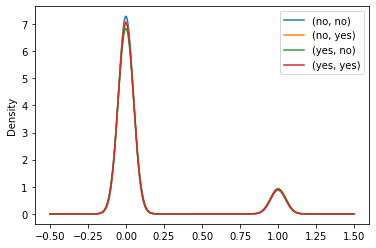

converted                
                         count      mean   sum
treatment new_images                          
no        no             10121  0.107104  1084
          yes            10121  0.112538  1139
yes       no             10121  0.120047  1215
          yes            10121  0.113724  1151

In [ ]:
groups['converted'].plot.kde()
plt.legend()
plt.show()

summary = groups.agg({'converted':['count', 'mean', 'sum']})
summary

The groups have exactly the same size, 10121 rows. The probability of a user joining the site changes with the design, with the control group being the less sucessful. It seems that it was a good idea to redesign the website!

However, the difference we want to measure is between 0.5 and 1.3%, which is very small.

## Methodology

### Summary

We will use A/B testing to compare the performance of each new design with the control group, using the conversion rate as metric. For that we will conduct an one tailed Z-test with a significance level of 0.05.

As part of the Z-test, we will execute a power analysis to check the probability of committing a type II error and calculate the lowest expected improvement with 95% of confidence.

### Definition of the metric *conversion rate*

We will use A/B testing to compare the performance of each experimental group with the control group. A common metric for A/B testing is the conversion rate, determined as

\begin{equation}
CR=\frac{n_{converted}}{n_{total}}
\end{equation}

In this case, because the data is binary, the conversion rate is equal to the mean.

### Definition of the hypothesis

Since we are only interested in an increase of user subscriptions, we will use a one-tailed hypothesis test

\begin{equation}
    \begin{aligned}
        H_0: p_1 - p_0 = 0\\
        H_1: p_1 - p_0 > 0 \\
    \end{aligned}
\end{equation}

where $p_1$ represents the conversion rate of an experimental group and $p_0$ represents the conversion rate of the control group. 

### General remarks of a Z-test

We will use a z-test to test our hypothesis. We can do it because:

- Sample sizes are equal;
- Our samples have 10121 observations (if it was less than 30, we would use a t-test);
- Observations are indendent from each other;
- Binomial distributions can be approximated to normal distributions. Moreover, for large samples (more than 30 observations) this is not a "hard" requirement.

When testing a hypothesis, we can incur two types of errors, type I and type II. Type I errors consist in rejecting the null hypothesis when the null hypothesis is true, while type II errors consist in failling to reject the null hypothesis when the null hypothesis is false. 

### Power Analysis

To calculate the probability of a type II error ocurring, we will conduct a power analysis. In terms of probabilities, power is described as

\begin{equation}
    \begin{aligned}
        Power &= P(\text{reject } H_0 | H_1 \text{ is true})\\
        &= 1 - P(\text{fail to reject } H_0 | H_1 \text{ is true})
    \end{aligned}    
\end{equation}

The library statsmodels.stats has some nice functions regarding power analysis and statistical tests. In this case we will use the NormalIndPower().power function, which requires the following parameters:

- **Effect size**: Measures the difference between two samples. Cohen's d will be used:
\begin{equation}
\text{Cohen's d} = \frac{\bar{x_1} - \bar{x_0}}{\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}}, \bar{x_1} > \bar{x_0}
\end{equation}
- **nobs1**: Number of observations of sample 0 (control group). Here it is 10121.
- **ratio**: Ratio of the number of observations in sample 1 relative to sample 0. Because the groups have the same size, it is 1.
- **$\alpha$**: The significance level is particularly relevant to calculate the probability of type I and type II errors. We will define $\alpha$ as 0.05, which corresponds to a 95% confidence interval.

A power analysis can provide some insights regarding the sample size. If needed, we can do a random sampling. 

In [ ]:
def cohen_d(s0, s1):
    std = np.sqrt((np.std(s0)**2 + np.std(s1)**2)/2)
    mean = np.mean(s1) - np.mean(s0)
    return np.abs(mean/std)

def do_power(s0, s1, alpha, nobs1=10121, ratio=1.0, alternative='larger'):
    effect_size = cohen_d(s0,s1)
    return NormalIndPower().power(effect_size=effect_size, nobs1 = nobs1, alpha=alpha,
                                  ratio=ratio, alternative=alternative)

In [ ]:
alpha = 0.05
summary[('converted', 'power')] = ""

group_ctrl = groups.get_group(("no", "no"))

for key in list(groups.groups.keys())[1:]:
    group_exp = groups.get_group(key)
    power = do_power(group_ctrl['converted'], group_exp['converted'], alpha)
    summary.loc[key, ('converted', 'power')] = power   
    
summary

converted                          
                         count      mean   sum     power
treatment new_images                                    
no        no             10121  0.107104  1084          
          yes            10121  0.112538  1139  0.341483
yes       no             10121  0.120047  1215  0.895739
          yes            10121  0.113724  1151  0.443471

Tipically, a power level of 0.8 is a good value. The group (yes, no) is the only with a larger value than 0.8. 
As for the size of the samples, ideally they should be even larger. As a result, we will use the whole samples.

### Z-test

The significance level, $\alpha$, we choose 0.05. We will determine the Z value corresponding to 1-0.05 (if it was a two tailed hypothesis we would find the Z corresponding to 1-0.05/2). We will call it $Z_\alpha$.

Then, we will calculate the Z of our hypothesis as

\begin{equation}
    \begin{aligned}
        Z &= \frac{p_1 - p_0 - \delta} {\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_0^2}{n_0}}}
    \end{aligned}    
\end{equation}

where $\delta$ is the value on the right side of the hypothesis (here 0).

If Z $\geq Z_\alpha$, then we reject the null hypothesis. In that case we will calculate the lower bound of the 95% confidence interval. 

The lower bound of the confidence interval is calculated as

\begin{equation}
    \begin{aligned}
        \text{lower bound} = (p_1 - p_0) - Z_\alpha {\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_0^2}{n_0}}}
    \end{aligned}    
\end{equation}

In [ ]:
def do_parameters(g_exp,g_ctrl):
    p1 = g_exp["converted"].mean()
    sigma1 = g_exp["converted"].std()
    n1 = g_exp["converted"].count()
    
    p0 = g_ctrl["converted"].mean()
    sigma0 = g_ctrl["converted"].std()
    n0 = g_ctrl["converted"].count()
    
    return [p1, sigma1, n1], [p0, sigma0, n0]


def do_zscore(g_exp,g_ctrl, val=0):
    
    exp, ctrl = do_parameters(g_exp,g_ctrl)
    
    return (exp[0] - ctrl[0] - val)/(np.sqrt(exp[1]**2/exp[2] + ctrl[1]**2/ctrl[2]))

def do_ci(g_exp, g_ctrl, Z):
    exp, ctrl = do_parameters(g_exp,g_ctrl)
    #upper = (exp[0] - ctrl[0]) + Z * (np.sqrt(exp[1]**2/exp[2] + ctrl[1]**2/ctrl[2]))
    lower = (exp[0] - ctrl[0]) - Z * (np.sqrt(exp[1]**2/exp[2] + ctrl[1]**2/ctrl[2]))
    return lower

In [ ]:
z_alpha = norm.ppf(1-alpha)
print("z_alpha: {}".format(z_alpha))
summary[('converted', 'zscore')] = ""

group_ctrl = groups.get_group(("no", "no"))

for key in list(groups.groups.keys())[1:]:
    group_exp = groups.get_group(key)
    zscore = do_zscore(group_exp, group_ctrl)
    summary.loc[key, ('converted', 'zscore')] = zscore   
    
summary

z_alpha: 1.6448536269514722


converted                                    
                         count      mean   sum     power    zscore
treatment new_images                                              
no        no             10121  0.107104  1084                    
          yes            10121  0.112538  1139  0.341483  1.236372
yes       no             10121  0.120047  1215  0.895739  2.902351
          yes            10121  0.113724  1151  0.443471  1.502605

We can only discard the null hypothesis for the group (yes, no).

In [ ]:
g_ctrl = groups.get_group(("no", "no"))
g_exp = groups.get_group(("yes", "no"))

lower = np.round(do_ci(g_exp, g_ctrl, z_alpha) * 100, 2)

print("The improvement of the design (yes, no) in relation to the control group, \
with 95% of confidence, is {}%.".format(lower))

print("\nFor the design (yes, no), the probability of commiting a type error I is {}%.".format(alpha*100))

print("\nFor the design (yes, no), the probability of commiting a type error II \
is {}%.".format(np.round( (1 - summary.loc[("yes", "no"), ("converted", "power")]) * 100, 2)))

The improvement of the design (yes, no) in relation to the control group, with 95% of confidence, is 0.56%.

For the design (yes, no), the probability of commiting a type error I is 5.0%.

For the design (yes, no), the probability of commiting a type error II is 10.43%.


## Conclusions

We performed an A/B test to compare the performance of three new designs of our landing page with the old design. 
We verified, with 95% of confidence, that when an user sees the new version of the landing page with the old images, 
the chances of them joining the site improve at least 0.56% in relation to the old design. Moreover, the probabilities of obtaining a false positive and a false negative are relatively small, with values of 5.00% and 10.43%, respectively. 

It is our recommendation that we use the new version of the landing page with the old images.